In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [9]:
print(image_datasets['train'].classes)

['ants', 'bees']


dir(image_datasets['train'])

In [27]:
print(image_datasets['train'])

In [ ]:
help(image_datasets['train'])

In [13]:
print(use_gpu)

False


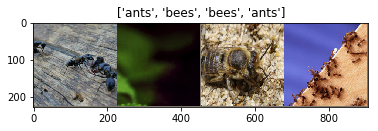

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

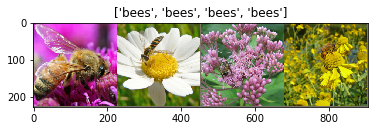

In [28]:
val_class_names = image_datasets['val'].classes
val_inputs, val_classes = next(iter(dataloders['val']))
# Make a grid from batch
val_out = torchvision.utils.make_grid(val_inputs)

imshow(val_out, title=[val_class_names[x] for x in val_classes])

In [2]:
model_ft = models.resnet18(pretrained=True)
help(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/hongjin/.torch/models/resnet18-5c106cde.pth
100.0%


Help on ResNet in module torchvision.models.resnet object:

class ResNet(torch.nn.modules.module.Module)
 |  Base class for all neural network modules.
 |  
 |  Your models should also subclass this class.
 |  
 |  Modules can also contain other Modules, allowing to nest them in
 |  a tree structure. You can assign the submodules as regular attributes::
 |  
 |      import torch.nn as nn
 |      import torch.nn.functional as F
 |  
 |      class Model(nn.Module):
 |          def __init__(self):
 |              super(Model, self).__init__()
 |              self.conv1 = nn.Conv2d(1, 20, 5)
 |              self.conv2 = nn.Conv2d(20, 20, 5)
 |  
 |          def forward(self, x):
 |             x = F.relu(self.conv1(x))
 |             return F.relu(self.conv2(x))
 |  
 |  Submodules assigned in this way will be registered, and will have their
 |  parameters converted too when you call .cuda(), etc.
 |  
 |  Method resolution order:
 |      ResNet
 |      torch.nn.modules.module.Module
 |   

In [4]:
fc = model_ft.fc
help(fc)

Help on Linear in module torch.nn.modules.linear object:

class Linear(torch.nn.modules.module.Module)
 |  Applies a linear transformation to the incoming data: :math:`y = Ax + b`
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to False, the layer will not learn an additive bias.
 |          Default: True
 |  
 |  Shape:
 |      - Input: :math:`(N, in\_features)`
 |      - Output: :math:`(N, out\_features)`
 |  
 |  Attributes:
 |      weight: the learnable weights of the module of shape
 |          (out_features x in_features)
 |      bias:   the learnable bias of the module of shape (out_features)
 |  
 |  Examples::
 |  
 |      >>> m = nn.Linear(20, 30)
 |      >>> input = autograd.Variable(torch.randn(128, 20))
 |      >>> output = m(input)
 |      >>> print(output.size())
 |  
 |  Method resolution order:
 |      Linear
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Method

In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

In [7]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
help(optimizer_ft)

Help on SGD in module torch.optim.sgd object:

class SGD(torch.optim.optimizer.Optimizer)
 |  Implements stochastic gradient descent (optionally with momentum).
 |  
 |  Nesterov momentum is based on the formula from
 |  `On the importance of initialization and momentum in deep learning`__.
 |  
 |  Args:
 |      params (iterable): iterable of parameters to optimize or dicts defining
 |          parameter groups
 |      lr (float): learning rate
 |      momentum (float, optional): momentum factor (default: 0)
 |      weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
 |      dampening (float, optional): dampening for momentum (default: 0)
 |      nesterov (bool, optional): enables Nesterov momentum (default: False)
 |  
 |  Example:
 |      >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
 |      >>> optimizer.zero_grad()
 |      >>> loss_fn(model(input), target).backward()
 |      >>> optimizer.step()
 |  
 |  __ http://www.cs.toronto.edu/%

In [6]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
help(exp_lr_scheduler)

Help on StepLR in module torch.optim.lr_scheduler object:

class StepLR(_LRScheduler)
 |  Sets the learning rate of each parameter group to the initial lr
 |  decayed by gamma every step_size epochs. When last_epoch=-1, sets
 |  initial lr as lr.
 |  
 |  Args:
 |      optimizer (Optimizer): Wrapped optimizer.
 |      step_size (int): Period of learning rate decay.
 |      gamma (float): Multiplicative factor of learning rate decay.
 |          Default: -0.1.
 |      last_epoch (int): The index of last epoch. Default: -1.
 |  
 |  Example:
 |      >>> # Assuming optimizer uses lr = 0.5 for all groups
 |      >>> # lr = 0.05     if epoch < 30
 |      >>> # lr = 0.005    if 30 <= epoch < 60
 |      >>> # lr = 0.0005   if 60 <= epoch < 90
 |      >>> # ...
 |      >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
 |      >>> for epoch in range(100):
 |      >>>     scheduler.step()
 |      >>>     train(...)
 |      >>>     validate(...)
 |  
 |  Method resolution order:
 |      

In [13]:
best_model_wts = model.state_dict()
for key in best_model_wts:
    print(key)

weight
bias


In [14]:
torch.max


<function torch._C.max>